In [ ]:
import h5py 
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
from PIL import Image
import os 
import skimage.io as io

THE ONLY DATA USED IN THIS PROGRAM IS all_mias_scans.h5
The problem of 322 and 330 is that: the class column is the label of the abnormality in the images which MAY NOT BE ONLY ONE. So some images has two labels because it has two tumors with different class. The classes are:
CALC Calcification CIRC Well-defined/circumscribed masses SPIC Spiculated masses MISC Other, ill-defined masses ARCH Architectural distortion ASYM Asymmetry NORM Normal
where only NORM means nothing abnormal happened, the others all says this image has a tumor with certain class

In [134]:
def clear2(lenaaa):
#This function is to clear the white line and bright spot of the images
    m = 0
    n = 0
    for i in range(0,1024):
        for j in range(512,1024):
            if lenaaa[i,j]==0:
                lenaaa[i,j:1024]=0
    return lenaaa


In [135]:
from numpy import *

'''通过方差的百分比来计算将数据降到多少维是比较合适的，
函数传入的参数是特征值和百分比percentage，返回需要降到的维度数num'''
def eigValPct(eigVals,percentage):
    
    
#This cell is simply a function i write to replace the PCA in sklearn,ignore the chinese words.


    sortArray=sort(eigVals) #使用numpy中的sort()对特征值按照从小到大排序
    sortArray=sortArray[-1::-1] #特征值从大到小排序
    arraySum=sum(sortArray) #数据全部的方差arraySum
    tempSum=0
    num=0
    for i in sortArray:
        tempSum+=i
        num+=1
        if tempSum>=arraySum*percentage:
            return num

'''pca函数有两个参数，其中dataMat是已经转换成矩阵matrix形式的数据集，列表示特征；
其中的percentage表示取前多少个特征需要达到的方差占比，默认为0.9'''
def pca(dataMat,percentage=0.9):
    meanVals=mean(dataMat,axis=0)  #对每一列求平均值，因为协方差的计算中需要减去均值
    meanRemoved=dataMat-meanVals
    covMat=cov(meanRemoved,rowvar=0)  #cov()计算方差
    eigVals,eigVects=linalg.eig(mat(covMat))  #利用numpy中寻找特征值和特征向量的模块linalg中的eig()方法
    k=4 #要达到方差的百分比percentage，需要前k个向量
    eigValInd=argsort(eigVals)  #对特征值eigVals从小到大排序
    eigValInd=eigValInd[:-(k+1):-1] #从排好序的特征值，从后往前取k个，这样就实现了特征值的从大到小排列
    redEigVects=eigVects[:,eigValInd]   #返回排序后特征值对应的特征向量redEigVects（主成分）
    lowDDataMat=meanRemoved*redEigVects #将原始数据投影到主成分上得到新的低维数据lowDDataMat
    reconMat=(lowDDataMat*redEigVects.T)+meanVals   #得到重构数据reconMat
    return lowDDataMat,reconMat

In [136]:
with h5py.File('C:/Users/nemow/Documents/479 project/all_mias_scans.h5', 'r') as scan_h5:
    bg_info = scan_h5['BG'][:]
    class_info = scan_h5['CLASS'][:]
    # low res scans
    scan_lr = scan_h5['scan'][:]
    index_lr = scan_h5['REFNUM'][:]
#read images
index = np.zeros(330)
coll = scan_lr
for i in range(0,330):
    index[i] = int(index_lr[i][3:6])
a = np.where(index%2 == 1)
for k in a:
    for i in range(0,1024):
        for j in range(0,512):
            u = coll[k,i,j]
            coll[k,i,j] = coll[k,i,1023-j]
            coll[k,i,1023-j] = u
#change right to left

In [137]:
coll[coll<40]=0
np.min(coll[coll>0])

40

In [138]:
for i in range(0,330):
    coll[i] = clear2(coll[i])

In [139]:
#image processing for some rare occasions
coll[287,960:1024,0:1024] = np.zeros((64,1024))
coll[287,400:1024,790:1024] = np.zeros((1,1))
coll[287,880:1000,500:600] = np.zeros((1,1))
coll[281,960:1024,0:1024] = np.zeros((64,1024))
coll[281,400:1024,790:1024] = np.zeros((1,1))
coll[281,900:1000,600:700] = np.zeros((1,1))

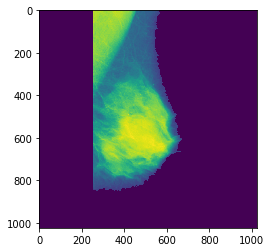

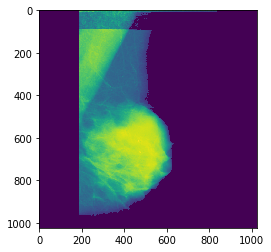

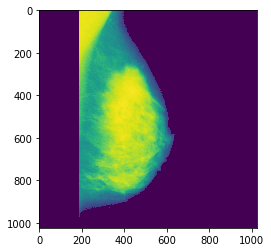

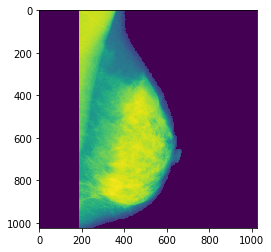

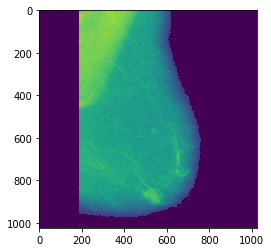

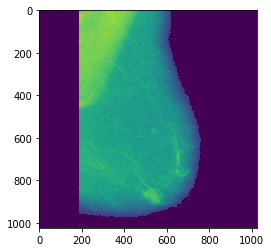

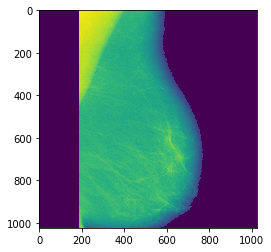

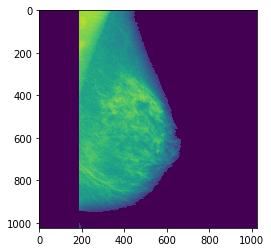

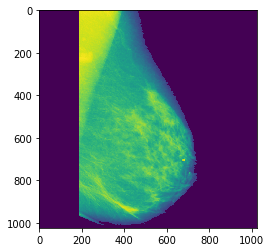

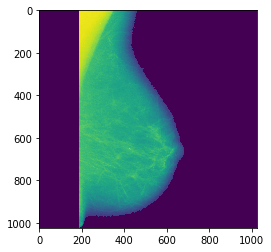

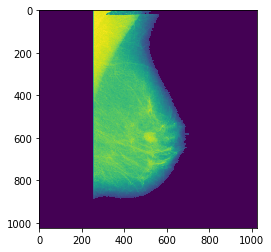

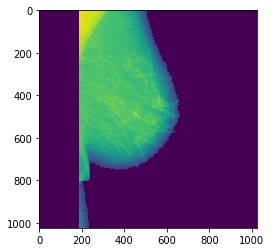

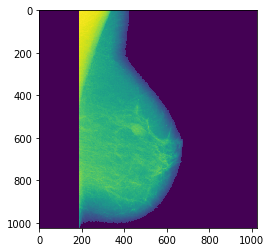

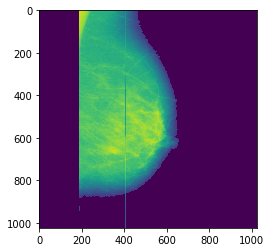

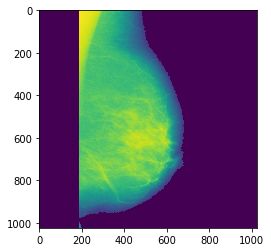

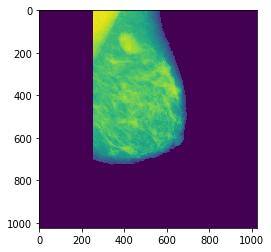

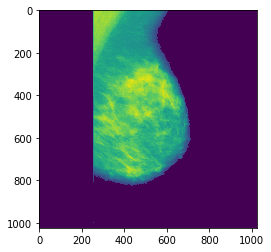

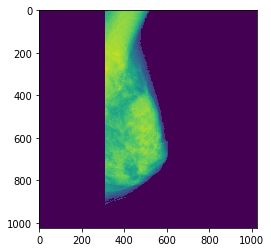

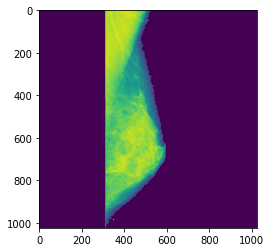

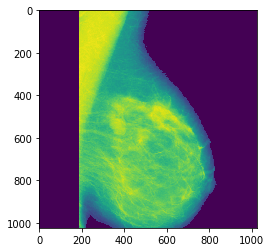

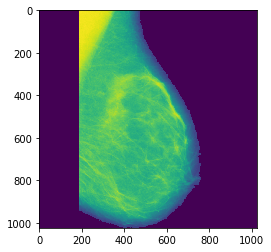

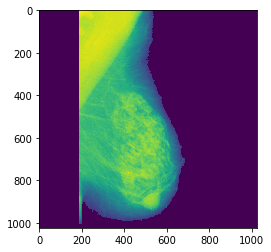

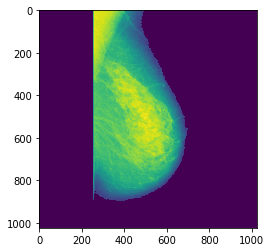

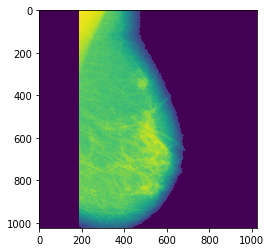

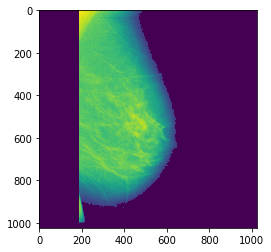

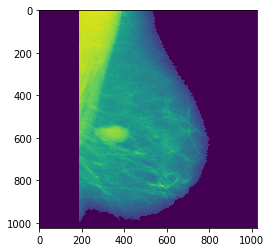

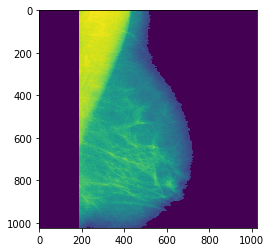

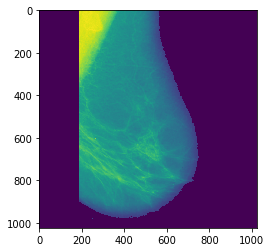

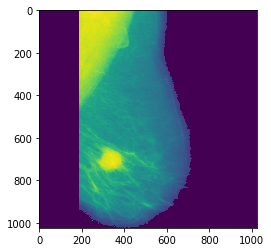

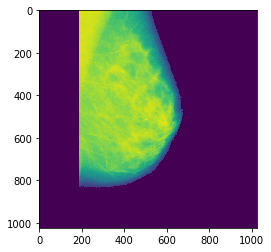

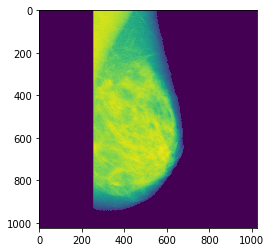

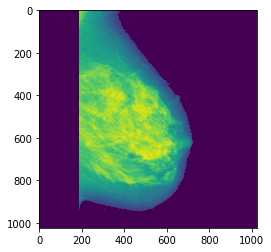

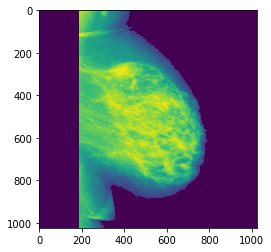

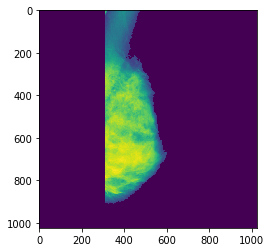

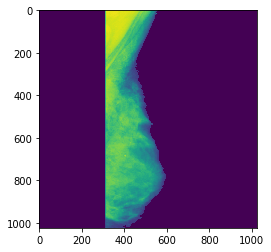

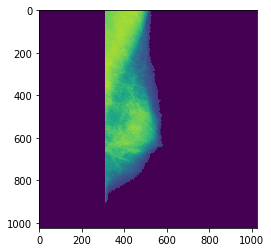

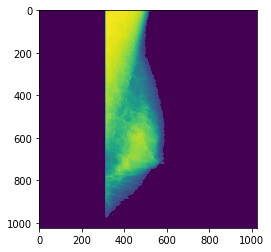

KeyboardInterrupt: 

In [140]:
#run this cell to see the result of pre-processing
for i in range(0,330):
    plt.imshow(coll[i])
    plt.show()

In [141]:
#using pca to do dimensional deduction
mmmm = np.zeros((330,1024,4))
for i in range(0,330):
    mmmm[i] = pca(coll[i])[0]

D:\anaconda\lib\site-packages\ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


In [142]:

#train test split
scan_lr_flat = mmmm.reshape((mmmm.shape[0],-1))
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
class_le.fit(class_info)
class_vec = class_le.transform(class_info)
class_le.classes_

from sklearn.model_selection import train_test_split
idx_vec = np.arange(scan_lr_flat.shape[0])
x_train, x_test, y_train, y_test, idx_train, idx_test = train_test_split(scan_lr_flat, 
                                                    class_vec, 
                                                    idx_vec,
                                                    random_state = 2017,
                                                   test_size = 0.5,
                                                   stratify = class_vec)
print('Training', x_train.shape)
print('Testing', x_test.shape)

Training (165, 4096)
Testing (165, 4096)


In [143]:
#a better report instead of only accuracy
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
creport = lambda gt_vec,pred_vec: classification_report(gt_vec, pred_vec, 
                                                        target_names = [x.decode() for x in 
                                                                        class_le.classes_])

In [153]:
#knn
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(10)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
print('Accuracy %2.2f%%' % (100*accuracy_score(y_test, y_pred)))
print(creport(y_test, y_pred))

Accuracy 61.21%
              precision    recall  f1-score   support

        ARCH       0.00      0.00      0.00         9
        ASYM       0.00      0.00      0.00         8
        CALC       0.00      0.00      0.00        15
        CIRC       0.00      0.00      0.00        13
        MISC       0.00      0.00      0.00         8
        NORM       0.62      0.98      0.76       103
        SPIC       0.00      0.00      0.00         9

   micro avg       0.61      0.61      0.61       165
   macro avg       0.09      0.14      0.11       165
weighted avg       0.39      0.61      0.47       165



D:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [145]:
#random forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)
print('Accuracy %2.2f%%' % (100*accuracy_score(y_test, y_pred)))
print(creport(y_test, y_pred))

Accuracy 57.58%
              precision    recall  f1-score   support

        ARCH       0.17      0.11      0.13         9
        ASYM       0.00      0.00      0.00         8
        CALC       0.17      0.13      0.15        15
        CIRC       0.60      0.23      0.33        13
        MISC       0.00      0.00      0.00         8
        NORM       0.64      0.86      0.74       103
        SPIC       0.00      0.00      0.00         9

   micro avg       0.58      0.58      0.58       165
   macro avg       0.22      0.19      0.19       165
weighted avg       0.47      0.58      0.51       165



D:\anaconda\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
